# 🧩 Notebook 08: Mixed Effects / Hierarchical Models

In [1]:
# Setup and Imports

import pandas as pd
from pathlib import Path
import sys

# ✅ Setup path to use utils
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Imports from utils
from utils.mixed_effects_utils import (
    fit_mixed_model,
    extract_random_effects,
    export_mixed_summary
)
from utils.model_utils import export_model_summary_as_text
from utils.visual_utils import save_and_show_plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import mixedlm

In [2]:
# Paths
DATA_PATH = Path("../synthetic_data")
EXPORT_PLOTS = Path("../exports/plots/08_mixed_effects")
EXPORT_TABLES = Path("../exports/tables/08_mixed_effects")
EXPORT_PLOTS.mkdir(parents=True, exist_ok=True)
EXPORT_TABLES.mkdir(parents=True, exist_ok=True)

In [3]:
# Load synthetic data with group-level variation
df = pd.read_csv(DATA_PATH / "heteroskedastic_data.csv")

In [4]:
# Simulate groups (e.g., schools, clinics)
np.random.seed(42)
df['group'] = np.random.choice(['A', 'B', 'C', 'D'], size=len(df))
df.head()

,X,y,group
0,-1.250696,0.723282,C
1,0.021944,2.667977,D
2,-2.064957,-5.701790,A
3,-0.685998,1.481319,C
4,-0.927784,3.579077,C


## 🔹 Step 1: Fit Random Intercept Model

In [5]:
# y ~ X with random intercept by group
formula = "y ~ X"
mixed_result = fit_mixed_model(df, formula=formula, groups_col="group")

# View summary
print(mixed_result.summary())

# Export summary
export_mixed_summary(mixed_result, EXPORT_TABLES / "mixed_model_summary.txt")


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y        
No. Observations: 200     Method:             REML     
No. Groups:       4       Scale:              7.5442   
Min. group size:  46      Log-Likelihood:     -486.3631
Max. group size:  54      Converged:          Yes      
Mean group size:  50.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.922    0.194 15.033 0.000  2.541  3.303
X             2.417    0.186 12.971 0.000  2.052  2.782
Group Var     0.000    0.049                           



/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 🔹 Step 2: Extract and Interpret Random Effects

In [6]:
# Extract and Interpret Random Effects

random_effects = extract_random_effects(mixed_result)
random_effects_df = pd.DataFrame(random_effects).T
random_effects_df.columns = ["Random Intercept"]
display(random_effects_df)

# Export
random_effects_df.to_csv(EXPORT_TABLES / "random_intercepts.csv")


,Random Intercept
A,-0.000050
B,0.000045
C,0.000023
D,-0.000018


## 🔹 Step 3: Plot Fitted Lines by Group

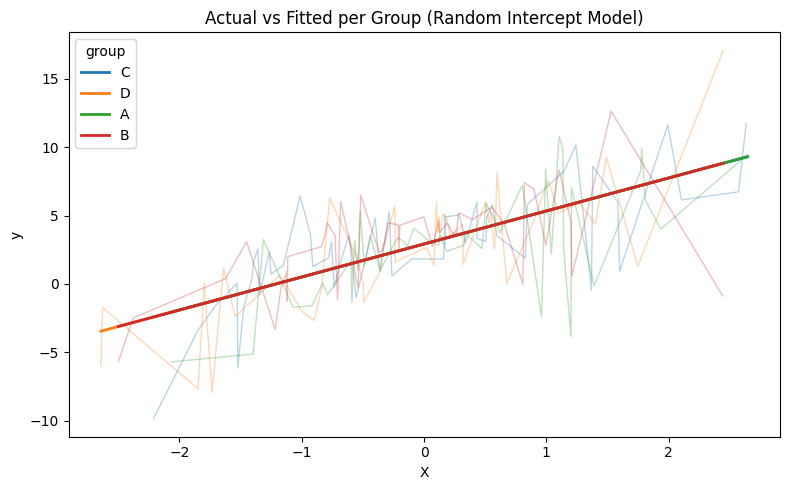

In [7]:
# Add fitted values
df["fitted"] = mixed_result.fittedvalues

# Plot actual vs fitted per group
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="X", y="y", hue="group", alpha=0.3, linewidth=1, legend=False)
sns.lineplot(data=df, x="X", y="fitted", hue="group", linewidth=2)
plt.title("Actual vs Fitted per Group (Random Intercept Model)")
save_and_show_plot("group_fitted_lines", EXPORT_PLOTS)

## 🔹 Step 4: Intraclass Correlation Coefficient (ICC)

In [8]:
# ICC = var_random / (var_random + var_residual)
var_random = mixed_result.cov_re.iloc[0, 0]
var_resid = mixed_result.scale
icc = var_random / (var_random + var_resid)
print(f"Intraclass Correlation Coefficient (ICC): {icc:.3f}")

Intraclass Correlation Coefficient (ICC): 0.000


## 🔹 Step 5: Random Slope Model

In [9]:
# Fit model with random slope

model_rs = mixedlm("y ~ X", data=df, groups=df["group"], re_formula="~X")
result_rs = model_rs.fit()
print(result_rs.summary())

export_mixed_summary(result_rs, EXPORT_TABLES / "mixed_model_random_slope.txt")

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: y        
No. Observations:  200     Method:             REML     
No. Groups:        4       Scale:              7.3888   
Min. group size:   46      Log-Likelihood:     -485.6032
Max. group size:   54      Converged:          No       
Mean group size:   50.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      2.919    0.210 13.914 0.000  2.508  3.331
X              2.402    0.277  8.676 0.000  1.859  2.945
Group Var      0.026    0.084                           
Group x X Cov -0.064    0.056                           
X Var          0.160    0.097                           



/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.war

## ✅ Summary
- Fitted a random intercept model using statsmodels.MixedLM
- Exported summary statistics and group-level random effects
- Visualized group-wise fitted lines over observed data
- Calculated Intraclass Correlation Coefficient (ICC) to quantify group variance
- Extended to random slope model for richer group-specific dynamics